In this notebook, we will take a look at data wrangling with TensorFlow, as well as at Recurrent Neural Networks and how to implement them im TensorFlow. We will also dive in more depth into the TensorFlow Data API. The notebook builds on a combination of the GitHub repositories by [Aurélien Géron](https://github.com/ageron/handson-ml2) and [Francois Chollet](https://github.com/fchollet/deep-learning-with-python-notebooks), and official TensorFlow tutorials.

In [1]:
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
import pandas
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (
    Flatten,
    Dense,
    SimpleRNN,
    BatchNormalization,
    LSTM,
    Conv1D,
    Embedding,
    GRU,
    GlobalAveragePooling1D,
    MaxPooling1D,
    Dropout,
)
from tensorflow.keras.metrics import mean_squared_error

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.24.3) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. TensorFlow Data API

We have used the TensorFlow Data API sometimes, without paying a lot of notice to it. For sequence predictions, however, a lot of complex data manipulation is necessary, so the functionality of the API can come in quite handy. Hence, we will take a brief look at some of the key features.

## 1.1 Generating and pre-processing data sets 

First of all, the Data API helps creating `Dataset`s made specifically for TensorFlow model training. It's quite straightforward to create a dataset from a list, matrix, array, or tensor:

In [2]:
example_array = np.array(
    [
        [1, 2, 3, 4],
        [5, 6, 7, 8],
        [9, 10, 11, 12],
        [13, 14, 15, 16],
        [17, 18, 19, 20],
        [21, 22, 23, 24],
    ]
)
dataset = tf.data.Dataset.from_tensor_slices(example_array)

2023-04-10 00:09:26.283381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We can iterate through a dataset, for example with a for-loop. This is exactly what our training algorithm will do

In [3]:
for item in dataset:
    print(item)


tf.Tensor([1 2 3 4], shape=(4,), dtype=int64)
tf.Tensor([5 6 7 8], shape=(4,), dtype=int64)
tf.Tensor([ 9 10 11 12], shape=(4,), dtype=int64)
tf.Tensor([13 14 15 16], shape=(4,), dtype=int64)
tf.Tensor([17 18 19 20], shape=(4,), dtype=int64)
tf.Tensor([21 22 23 24], shape=(4,), dtype=int64)


We can also inspect the type of data to be found in a `Dataset`:

In [4]:
dataset.element_spec


TensorSpec(shape=(4,), dtype=tf.int64, name=None)

The most important aspect about working with datasets is that we can directly apply some very important operations. One is to shuffle the data in the set. Especially when the dataset is large, we don't want to shuffle it too much, since this takes time. Hence, the `shuffle` operation is parametrized with a `'buffer_size'`. This controls how many elements are considered to fill the the current slot. E.g., when deciding what to place in first slot, the randomizer will consider only the first `'buff_size'` items. Run the following code a few times to see exactly how the randomization operates (note that `[13,14,15,16]` will never appear in the first spot, `[17,18,19,20]` will never appear in the first or second spot, and so on)

In [5]:
dataset_new = dataset.shuffle(3)
for item in dataset_new:
    print(item)


tf.Tensor([5 6 7 8], shape=(4,), dtype=int64)
tf.Tensor([1 2 3 4], shape=(4,), dtype=int64)
tf.Tensor([17 18 19 20], shape=(4,), dtype=int64)
tf.Tensor([13 14 15 16], shape=(4,), dtype=int64)
tf.Tensor([21 22 23 24], shape=(4,), dtype=int64)
tf.Tensor([ 9 10 11 12], shape=(4,), dtype=int64)


The best part about using the Data API is that these operations happen at runtime. Hence, we only need to have enough memory for the original dataset, but not for all the possible randomized versions that might be called up when training a neural network (keep in mind that in each epoch the randomization is different, unless we specify `reshuffle_each_iteration=False`)

Another important feature of `Dataset`s is that we can batch together a number of data points. This is very important to perform mini-batch gradient descent.

**Code**: Generate a `dataset_new` using `datatset.batch(k)` where `k` is a number of your choice. Then print out the items of your new dataset to see what is happening.

In [6]:
dataset_new = dataset.batch(3)
for item in dataset_new:
    print(item)


tf.Tensor(
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]], shape=(3, 4), dtype=int64)
tf.Tensor(
[[13 14 15 16]
 [17 18 19 20]
 [21 22 23 24]], shape=(3, 4), dtype=int64)


What do you think happens when the size of the dataset is not divisible by the batch size? Try it out!

We can also `repeat` the data in our dataset (either a pre-specified number of times or infinitely often if we don't specify a number). The `take` operation specifies how many of the elements of the datasets to take out (in FIFO order!)

In [7]:
dataset_new = dataset.repeat().take(18)
for item in dataset_new:
    print(item)


tf.Tensor([1 2 3 4], shape=(4,), dtype=int64)
tf.Tensor([5 6 7 8], shape=(4,), dtype=int64)
tf.Tensor([ 9 10 11 12], shape=(4,), dtype=int64)
tf.Tensor([13 14 15 16], shape=(4,), dtype=int64)
tf.Tensor([17 18 19 20], shape=(4,), dtype=int64)
tf.Tensor([21 22 23 24], shape=(4,), dtype=int64)
tf.Tensor([1 2 3 4], shape=(4,), dtype=int64)
tf.Tensor([5 6 7 8], shape=(4,), dtype=int64)
tf.Tensor([ 9 10 11 12], shape=(4,), dtype=int64)
tf.Tensor([13 14 15 16], shape=(4,), dtype=int64)
tf.Tensor([17 18 19 20], shape=(4,), dtype=int64)
tf.Tensor([21 22 23 24], shape=(4,), dtype=int64)
tf.Tensor([1 2 3 4], shape=(4,), dtype=int64)
tf.Tensor([5 6 7 8], shape=(4,), dtype=int64)
tf.Tensor([ 9 10 11 12], shape=(4,), dtype=int64)
tf.Tensor([13 14 15 16], shape=(4,), dtype=int64)
tf.Tensor([17 18 19 20], shape=(4,), dtype=int64)
tf.Tensor([21 22 23 24], shape=(4,), dtype=int64)


Using `map`, we can apply a function to all the elements of the dataset. We could specify the function somewhere else and call it here, but the quickest way to implement this is using so-called "lambda functions". Here, for example, we take every element from the dataset (and we call such an element `x`), then we multiply it by `2`.

In [8]:
dataset_new = dataset.map(lambda x: x * 2)
for item in dataset_new:
    print(item)

tf.Tensor([2 4 6 8], shape=(4,), dtype=int64)
tf.Tensor([10 12 14 16], shape=(4,), dtype=int64)
tf.Tensor([18 20 22 24], shape=(4,), dtype=int64)
tf.Tensor([26 28 30 32], shape=(4,), dtype=int64)
tf.Tensor([34 36 38 40], shape=(4,), dtype=int64)
tf.Tensor([42 44 46 48], shape=(4,), dtype=int64)


Similarly, we can filter the data, specifying a function that determines whether the current observation should be added into the iteration or not. Again, lambda functions can be useful here.

**Code**: Can you come up with a lambda-function that uses a filter to only keep observations where the last entry is greater `6`? 

In [9]:
dataset_new = dataset.filter(lambda x: x[-1] > 6)
for item in dataset_new:
    print(item)

tf.Tensor([5 6 7 8], shape=(4,), dtype=int64)
tf.Tensor([ 9 10 11 12], shape=(4,), dtype=int64)
tf.Tensor([13 14 15 16], shape=(4,), dtype=int64)
tf.Tensor([17 18 19 20], shape=(4,), dtype=int64)
tf.Tensor([21 22 23 24], shape=(4,), dtype=int64)


**Code**: How about one where all elements have to be greater `8`? `tf.math.reduce_any` might come in useful here (it works like `any` in base Python).

In [10]:
dataset_new = dataset.filter(lambda x: tf.math.reduce_any(x > 8))
for item in dataset_new:
    print(item)

tf.Tensor([ 9 10 11 12], shape=(4,), dtype=int64)
tf.Tensor([13 14 15 16], shape=(4,), dtype=int64)
tf.Tensor([17 18 19 20], shape=(4,), dtype=int64)
tf.Tensor([21 22 23 24], shape=(4,), dtype=int64)


Note that we can apply multiple operations to the same dataset by just adding them sequentially:

In [11]:
dataset_new = dataset.map(lambda x: x * 2).batch(3)
for item in dataset_new:
    print(item)

tf.Tensor(
[[ 2  4  6  8]
 [10 12 14 16]
 [18 20 22 24]], shape=(3, 4), dtype=int64)
tf.Tensor(
[[26 28 30 32]
 [34 36 38 40]
 [42 44 46 48]], shape=(3, 4), dtype=int64)


### A slightly more complex example

We will now load some images from the `mnist` dataset. Don't worry too much about the content, the key here is how we will process them as a `Dataset`.

In [12]:
DATA_URL = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz"

path = tf.keras.utils.get_file("mnist.npz", DATA_URL)
with np.load(path) as data:
    train_examples = data["x_train"]
    train_labels = data["y_train"]
    test_examples = data["x_test"]
    test_labels = data["y_test"]

In [13]:
print(train_examples.shape)
print(train_labels.shape)


(60000, 28, 28)
(60000,)


We used TensorFlow to download the images into a folder (you can see which one by typing in `print(path)`). We also loaded each of `x_train`, `y_train`, `x_test`, and `y_test` as a numpy array. We will now directly convert the numpy arrays into datasets (one for training, one for testing). The code below shows you how to combine `x` and `y` into a single dataset, using tuples:

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_examples, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))


As before, we can easily check what our dataset contains. We see that the `x`-data are arrays of shape (28,28) and the `y`-data are individual points (i.e., a number indicating the class that the image belongs to)

We will now shuffle and batch our training dataset.

**Code**: Can you apply the `shuffle` operation (with a shuffle buffer size of 100) to the `train_dataset`, followed by the `batch` operation (with a batch size of 128)? For the testing dataset, we don't need to shuffle it, so simply apply the `batch` operation.

In [16]:
batch_size = 128
shuffle_buffer_size = 100

train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
test_dataset, train_dataset

(<BatchDataset element_spec=(TensorSpec(shape=(None, None, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(None, None), dtype=tf.uint8, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, None, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(None, None), dtype=tf.uint8, name=None))>)

With the line below, you can see how data is now returned: in batches of size 128 each!

In [17]:
for item in train_dataset:
    print("x-shape: " + str(item[0].shape) +
          " | y-shape:" + str(item[1].shape))
    break


x-shape: (128, 128, 28, 28) | y-shape:(128, 128)


Finally, we usually want to call `prefetch(1)` when we build a `Dataset` in this manner. The reason is, that our `Dataset` will work in parallel with the training process and things will speed up a lot. The following illustration from Geron, 2022, shows exactly why `prefetch` is useful:

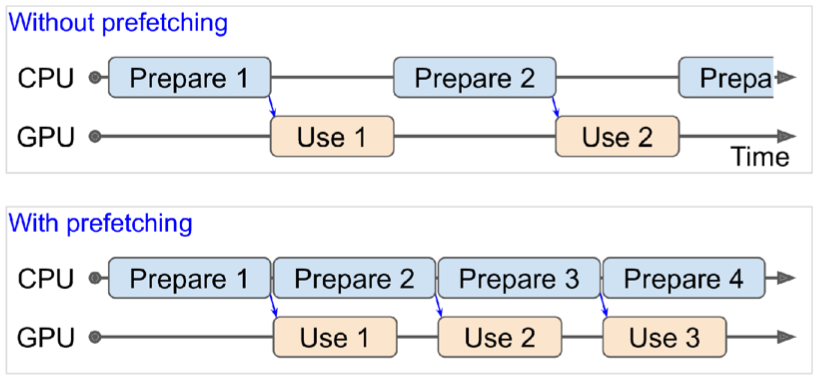

In [18]:
train_dataset = train_dataset.prefetch(1)
test_dataset = test_dataset.prefetch(1)


We can now train our models using `train_dataset` instead of `x` and `y`, and evaluate them using `test_dataset`

## 1.2 Dealing with data that doesn't fit into memory

Sometimes, even the original dataset doesn't fit into memory, before any of the pre-procesisng. In this case, we want to load data on the fly.

We already saw the `ImageDataGenerator`, which can take images directly from files and generate a `flow` of images at runtime. More generally, TensorFlow provides the TFRecord format to save data and load it on the fly through a `TFRecordDataset`. Let's create some data in the right format, and call it into a dataset:

In [19]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")


In [20]:
dataset = tf.data.TFRecordDataset(["my_data.tfrecord"])
for item in dataset:
    print(item)


tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


Want to also save hard drive space?
We can also call up data without decompressing it. In the code below, we create a compressed TFRecord folder, and load from this folder without a complete decompression. Data is decompressed on the fly, too.

In [21]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")


In [22]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"], compression_type="GZIP")
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


# 2. A timeseries prediction example

## 2.1 Preparing the data

We start by fetching the data. If you have the "climate_data.csv" file in the same folder as the notebook, there is no need to do anything here (just leave `google = False`). If you are running on Colab, make sure to adjust to `google = True`.

In [23]:
google = False

if google:
    from google.colab import drive

    drive.mount("/content/gdrive")
    path = "gdrive/MyDrive/"
else:
    path = ""

The data collects the temperature and other temperature-related indicators over a multi-year horizon in ten minutes interval. We load the data, then print out the column names to see what kind of variables we have available.

In [24]:
fname = os.path.join(path + "climate_data.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


Next, we convert the data into arrays. In particular, we will create a vector of temperature values over time (this is what we are trying to predict), and an array of regressors over time (this will also include the temperature values - after all, temperature on day t is very predictive of temperature on day t+1).

In [25]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [
        float(x) for x in line.split(",")[1:]
    ]  # Date Time is irrelevant, as data is equally spaced, so we drop it
    temperature[i] = values[
        1
    ]  # We store the temperature (this is what we will predict)
    raw_data[i, :] = values[
        :
    ]  # We store all data points (including the temperature), which will be our predictors
print(temperature.shape)
print(raw_data.shape)

(420451,)
(420451, 14)


Let's take a look at the temperature over time:

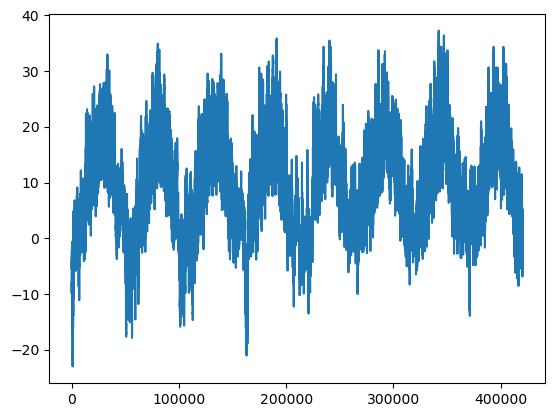

In [26]:
plt.plot(range(len(temperature)), temperature)


We next specify the size of the training and validation dataset (the test set will be the rest). Keep in mind that with time series data we don't subdivide at random, but we take the first part as training and the later part as validation/testing data.

**Discussion**: Why are we not randomly subdividing the data?

In [27]:
train_size = int(0.5 * len(raw_data))
valid_size = int(0.25 * len(raw_data))


We standardize the data. In particular, we use the mean and standard deviation **of the training data** to standardize.

**Discussion**: Why do we not use the mean and standard deviation of the whole data here?

In [28]:
mean = raw_data[:train_size].mean(axis=0)
std = raw_data[:train_size].std(axis=0)
raw_data = (raw_data - mean) / std

Now, we use `tf.keras.utils.timeseries_dataset_from_array` to create a `Dataset` object that is formatted "correctly" for a time series prediction task. In partcular, we need to specify
- The length of the sequences used to make predictions
- The "delay", that is, the time after the start of the input sequences when we start to make predictions
- The batch size in which our data set returns inputs and targets.

We make a small example below, to visualize this. Feelf ree to play around with the main variables to see better what is happening here.

In [29]:
int_sequence = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
delay = 4
dummy_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-delay],
    targets=int_sequence[delay:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    print("Next batch:")
    for i in range(inputs.shape[0]):
        print("   input:", [int(x) for x in inputs[i]], "| output:", int(targets[i]))

Next batch:
   input: [0, 1, 2] | output: 4
   input: [1, 2, 3] | output: 5
Next batch:
   input: [2, 3, 4] | output: 6
   input: [3, 4, 5] | output: 7
Next batch:
   input: [4, 5, 6] | output: 8
   input: [5, 6, 7] | output: 9
Next batch:
   input: [6, 7, 8] | output: 10


In [30]:
int_sequence[:-4]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [31]:
int_sequence[delay:]

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12])

Let's now scale things up and create the actual data set. The main difference to our trial is that we specify also the `start_index` and the `end_index`, in order to allow us to create training/validation/testing datasets from different parts of the sequence. We also define a `sampling_rate` here.

We specify our prediction problem as follows:
- We use sequences of 120 observations to make a prediction about the temperature one day (24 hours) after the last observation
- We create batches of size 256
- We sample at a `sampling_rate` of 6, meaning that we only take every 6th data point (so we measure temperature per hour rather than per ten minutes).

In [32]:
sampling_rate = 6
sequence_length = 120
batch_size = 256


def create_timeseries_dataset(start_index, end_index):
    delay = sampling_rate * (sequence_length + 24 - 1)
    data_set = tf.keras.utils.timeseries_dataset_from_array(
        data=raw_data[:-delay],
        targets=temperature[delay:],
        sampling_rate=sampling_rate,
        sequence_length=sequence_length,
        shuffle=True,
        batch_size=batch_size,
        start_index=start_index,
        end_index=end_index,
    )
    return data_set

In [33]:
sampling_rate * (sequence_length + 24 - 1)

858

In [34]:
train_dataset = create_timeseries_dataset(0, train_size)
val_dataset = create_timeseries_dataset(train_size, train_size + valid_size)
test_dataset = create_timeseries_dataset(train_size + valid_size, None)


Finally, a quick look at a single batch from the training data, to see if everything worked as intended:

In [35]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break


samples shape: (256, 120, 14)
targets shape: (256,)


## 2.2 Establishing some baselines

It tends to be quite easy to predict only a few steps ahead. For example, if you want a very good prediction for the weather tomorrow, just take the weather today. Of course, it varies a bit by location, but in many places that already gives you a great prediction. We will use this as a baseline, and we will also build a simple dense neural network.

### Predicting tomorrow based on today

Our first approach is to take our last observation of an input sequence, and simply predict that tomorrow's temperature will be the same as today's. Keep in mind that we standardized the input, so we have to "destandardize" to get back to a temperature reading.

**Discussion**: What do you think of this baseline? Are we doing an accurate job predicting temperatures?

In [36]:
def naive_method(dataset):
    total_abs_err = 0.0
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen


print(f"Train MAE: {naive_method(train_dataset):.2f}")
print(f"Validation MAE: {naive_method(val_dataset):.2f}")
print(f"Test MAE: {naive_method(test_dataset):.2f}")

Train MAE: 2.69
Validation MAE: 2.44
Test MAE: 2.62


### A (simple) dense network

Our second approach is to build a simple (dense) neural network. In particular, we take each sequence of data point and flatten it, in order to run it through a Dense layer with `"relu"` activation. We then have a final Dense layer to make a prediction.

**Discussion**: Why are we not using any activation function for the second Dense layer here?

In [37]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(sequence_length, raw_data.shape[-1])),
        Flatten(),
        Dense(16, activation="relu"),
        Dense(1),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1680)              0         
                                                                 
 dense (Dense)               (None, 16)                26896     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________


Next, train the model. 

**Discussion**: What do you observe? Would you re-evaluate your previous baseline?

In [38]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("temp_dense", save_best_only=True)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset, epochs=5, validation_data=val_dataset, callbacks=[checkpoint_cb]
)

model = tf.keras.models.load_model("temp_dense")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 18s 21ms/step - loss: 11.6076 - mae: 2.6462 - val_loss: 10.8364 - val_mae: 2.5897
Epoch 2/5
819/819 [==============================] - 17s 20ms/step - loss: 8.8125 - mae: 2.3363 - val_loss: 10.2043 - val_mae: 2.5219
Epoch 3/5
819/819 [==============================] - 17s 21ms/step - loss: 8.2493 - mae: 2.2620 - val_loss: 10.7489 - val_mae: 2.5947
Epoch 4/5
819/819 [==============================] - 18s 22ms/step - loss: 7.8494 - mae: 2.2077 - val_loss: 11.0327 - val_mae: 2.6109
Epoch 5/5
405/405 [==============================] - 7s 16ms/step - loss: 11.2802 - mae: 2.6376
Test MAE: 2.64


## 2.3 A first try with 1D convolutions

One-dimensional convolutional layers work exactly like two-dimensional convolutional layers. Except that they are one-dimensional, of course. They help to transmit a sequence into a smaller sequence. You can visualize the what happens in the layer below as follows:

```
1D conv layer with kernel size 4, stride 2, VALID padding:


Input:
   0  1  2  3  4  5  6  7  8  9  10 11 12 ...112 113 114 115 116 117 118 119
              |-----2-----|     |-----5---...-------|        |------58-----|
        |-----1-----|     |-----4-----|   ...       |------57-----|
  |-----0----|      |-----3-----|     |---...|------56-----|

Output:
       0-3   2-5   4-7   6-9   8-11 10-13 ...-113 112-115 114-117 116-119
```

Let's try it out. Below, we create a CNN for sequences (including convolutions, max poling, and global average pooling).

In [57]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(sequence_length, raw_data.shape[-1])),
        Conv1D(8, 24, activation="relu"),
        MaxPooling1D(2),
        Conv1D(8, 12, activation="relu"),
        MaxPooling1D(2),
        Conv1D(8, 6, activation="relu"),
        GlobalAveragePooling1D(),
        Dense(1),
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 97, 8)             2696      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 18, 8)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 8)             392       
                                                                 
 global_average_pooling1d (G  (None, 8)               

In [38]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("temp_cnn", save_best_only=True)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset, epochs=8, validation_data=val_dataset, callbacks=[checkpoint_cb]
)

model = tf.keras.models.load_model("temp_cnn")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/8


2023-03-27 14:08:02.960249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - ETA: 0s - loss: 23.4545 - mae: 3.7634

2023-03-27 14:08:16.865643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: temp_cnn/assets


INFO:tensorflow:Assets written to: temp_cnn/assets


819/819 [==============================] - 19s 22ms/step - loss: 23.4545 - mae: 3.7634 - val_loss: 15.4049 - val_mae: 3.0963
Epoch 2/8
819/819 [==============================] - 18s 22ms/step - loss: 15.2752 - mae: 3.0928 - val_loss: 15.9493 - val_mae: 3.1501
Epoch 3/8
819/819 [==============================] - ETA: 0s - loss: 14.0750 - mae: 2.9635

INFO:tensorflow:Assets written to: temp_cnn/assets


INFO:tensorflow:Assets written to: temp_cnn/assets


819/819 [==============================] - 19s 22ms/step - loss: 14.0750 - mae: 2.9635 - val_loss: 13.9171 - val_mae: 2.9403
Epoch 4/8
819/819 [==============================] - 17s 21ms/step - loss: 13.2471 - mae: 2.8750 - val_loss: 16.7535 - val_mae: 3.2611
Epoch 5/8
819/819 [==============================] - 17s 21ms/step - loss: 12.7010 - mae: 2.8133 - val_loss: 16.1729 - val_mae: 3.1614
Epoch 6/8
819/819 [==============================] - 17s 21ms/step - loss: 12.2323 - mae: 2.7633 - val_loss: 14.1629 - val_mae: 2.9549
Epoch 7/8
819/819 [==============================] - 17s 21ms/step - loss: 11.8040 - mae: 2.7149 - val_loss: 14.9629 - val_mae: 3.0055
Epoch 8/8
819/819 [==============================] - ETA: 0s - loss: 11.4380 - mae: 2.6741

INFO:tensorflow:Assets written to: temp_cnn/assets


INFO:tensorflow:Assets written to: temp_cnn/assets


  1/405 [..............................] - ETA: 1:27 - loss: 17.0281 - mae: 3.2774

2023-03-27 14:10:26.308406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


405/405 [==============================] - 5s 11ms/step - loss: 15.5220 - mae: 3.0956
Test MAE: 3.10


This doesn't even come close to the simple baseline. Probably because this is not a great example when it comes to the translation invariance assumption.

# 3. Understanding recurrence in TensorFlow

We start with a very simple RNN, with only one recurrent layer. Note that our input has a certain number of features, `num_features`, as well as a certain sequence-length, which for now is just `None`. Play around with the features and the number of recurrent neurons. What do you notice?

**Discussion**: Does the number of parameters make sense to you? How would you compute it?

In [39]:
num_features = 2
model = tf.keras.Sequential([tf.keras.Input(shape=(None, num_features)), SimpleRNN(2)])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 2)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


So far, our layer has taken a sequence, and returned a single output - corresponding to the last value of the actual output sequence. We can, instead, return the whole sequence, by setting `return_sequences=True`.

**Discussion**: How does the output change, and where does the difference come from?

In [40]:
num_features = 2
model = tf.keras.Sequential(
    [tf.keras.Input(shape=(None, num_features)), SimpleRNN(2, return_sequences=True)]
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 2)           10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


So far, we have not specified the length of the input sequences. This is useful if we have variable sequences. However, we usually want fixed-length sequences, because this can improve performance a lot (if we have actually different lengths, we can also just use "masking", as we will see later). Try out creating a network with a specified sequence length:

In [41]:
num_features = 2
num_steps = 120
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(num_steps, num_features)),
        SimpleRNN(2, return_sequences=True),
    ]
)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 120, 2)            10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


Let's go deeper. If we have multiple layers of recurrent nodes, we need to consider what to pass on between layers. In particular, we need to set `return_sequences=True` in a recurrent layer, so that all outputs are passed to the next layer. Otherwise, only the last otuput (corresponding to the last time step) is passed to the next layer (which means the layer does not receive a sequence). Try out the code below:

In [45]:
num_features = 14
num_steps = 120
model = tf.keras.Sequential(
    [tf.keras.Input(shape=(num_steps, num_features)), SimpleRNN(8), SimpleRNN(8)]
)
model.summary()

ValueError: Input 0 of layer "simple_rnn_8" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 8)

Let's try this again, specying `return_sequences=True` for our intermediate layer.

**Discussion**: What is the main difference? Why does it work this time?

In [46]:
num_features = 14
num_steps = 120
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(num_steps, num_features)),
        SimpleRNN(8, return_sequences=True),
        SimpleRNN(8),
    ]
)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, 120, 8)            184       
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 8)                 136       
                                                                 
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________


### Dropouts in RNNs

You could add a Dropout layer between recurrent layers. However, this won't work very well, because you want to ensure that the same dropout mask is applied to each timestep.

Hence, recurrent layers have a `dropout` argument, that lets you specify dropouts more correctly. However, this will only drop out the actual inputs. If you want to drop out also the input from the previous step, you have to specify the `recurrent_dropout` argument.

Finally, of course you can still add Dropout layers to dropout inputs into non-recurrent layers.

In [47]:
num_features = 14
num_steps = 120
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(num_steps, num_features)),
        SimpleRNN(8, return_sequences=True, dropout=0.2, recurrent_dropout=0.25),
        SimpleRNN(8),
        Dropout(0.3),
        Dense(1),
    ]
)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_11 (SimpleRNN)   (None, 120, 8)            184       
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


**A note for advanced usage**: One difficulty of recurrent layers is that they naturally contain a for loop - you can't compute the second period operation without the first period operation. As a result, small RNNs will actually run faster on CPUs than on GPUs, because the CPUs' advantage of flexibility outweighs the scaling advantages of GPUs.

As a result, modern NVIDIA GPUs have some specific speed-up techniques (called "cuDNN kernels"). These support most "standard" layers, but not all additional options. For example, if you add `recurrent_dropout`, there is no cuDNN implementation, so your training will default to a "normal" GPU implementation and might not be much faster than when using a CPU. Within limits, you can still speed up the process in these cases, by manually "unrolling" your RNN for-loop - basically, making sure that your GPU can still parallelize the operations. This will cost a lot of memory, however, so it's only useful for short sequences.

In [48]:
num_features = 14
num_steps = 120
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(num_steps, num_features)),
        SimpleRNN(
            8, return_sequences=True, dropout=0.2, recurrent_dropout=0.25, unroll=True
        ),
        SimpleRNN(8, unroll=True),
        Dropout(0.3),
        Dense(1),
    ]
)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_13 (SimpleRNN)   (None, 120, 8)            184       
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


# 4. A (complex) recurrent network for our temperature prediction task

Let's put some of what we learned together and build a (more complex) RNN to predict the weather. Note that this will take quite some time to train on a CPU.

In [49]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(sequence_length, raw_data.shape[-1])),
        GRU(32, recurrent_dropout=0.5, return_sequences=True),
        GRU(32, recurrent_dropout=0.5),
        Dropout(0.5),
        Dense(1),
    ]
)
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 120, 32)           4608      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10,977
Trainable params: 10,977
Non-trainable params: 0
_________________________________________________________________


In [50]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("temp_gru", save_best_only=True)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset, epochs=8, validation_data=val_dataset, callbacks=[checkpoint_cb]
)

model = tf.keras.models.load_model("temp_gru")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/8


2023-03-27 14:14:13.794033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  4/819 [..............................] - ETA: 8:16:22 - loss: 145.7177 - mae: 9.9645

We are clearly doing better now! However, note that the improvement is not massive in absolute terms compared to simply predicting today's temperature for tomorrow.

How could you do even better?
- Adjust the learning rate, the number of units, and the dropout
- Use multiple `Dense` layers at the end, rather than just a single one (similar to how most CNNs have a stack of Dense layers at the end)
- Change the input, e.g., using longer or shorter sequences, or some feature engineering

# 5. Forecasting multiple timesteps: a sequence-to-vector approach

So far, we have only forecast one timestep. We will now forecast the temperature for the entire next day, instead. For this, we have to recreate our datasets accordingly. To see how to create the correct dataset, let's start with a simple dummy example. The idea is that we create two datasets, one for input sequences, and one for output sequences, then add them together to have a single dataset to call when fitting the model.

In [95]:
int_sequence = np.arange(18)
sequence_length_input = 4
sequence_length_output = 2
delay = sequence_length_input + 1
batch_size = 4


def create_multiple_dummy_datasets(start_index, end_index):
    dummy_input_data = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=int_sequence[:-delay],
        targets=None,
        sequence_length=sequence_length_input,
        start_index=start_index,
        end_index=end_index,
        batch_size=1,
    ).unbatch()  # We create "unbatched" datasets, since we want to merge the data one by one
    dummy_target_data = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=int_sequence[delay:],
        targets=None,
        sequence_length=sequence_length_output,  # The length of the output sequences may be different from the length of the input sequences
        start_index=start_index,
        end_index=end_index,
        batch_size=1,
    ).unbatch()  # We create "unbatched" datasets, since we want to merge the data one by one
    return tf.data.Dataset.zip((dummy_input_data, dummy_target_data)).batch(
        batch_size
    )  # We merge the two datasets and then batch them


train_dummies = create_multiple_dummy_datasets(0, 8)
val_dummies = create_multiple_dummy_datasets(8, None)

for data in [train_dummies, val_dummies]:
    print("Next data set:")
    for inputs, targets in data:
        print("    Next batch:")
        for i in range(targets.shape[0]):
            print(
                "       input:",
                [int(x) for x in inputs[i]],
                "| output:",
                [int(x) for x in targets[i]],
            )

Next data set:
    Next batch:
       input: [0, 1, 2, 3] | output: [5, 6]
       input: [1, 2, 3, 4] | output: [6, 7]
       input: [2, 3, 4, 5] | output: [7, 8]
       input: [3, 4, 5, 6] | output: [8, 9]
    Next batch:
       input: [4, 5, 6, 7] | output: [9, 10]
Next data set:
    Next batch:
       input: [8, 9, 10, 11] | output: [13, 14]
       input: [9, 10, 11, 12] | output: [14, 15]


Once we have understood how to combine two data sets in order to generate input and output sequence, we can scale it up to create our actual datasets.

**Code**: Can you complete the code below to ensure that our targets are 24 steps after the specified delays?

In [90]:
sampling_rate = 6
sequence_length_input = 120
sequence_length_output = 24
delay = sampling_rate * (sequence_length_input + 24 - 1)
batch_size = 256


def create_multiple_datasets(start_index, end_index):
    input_data = tf.keras.utils.timeseries_dataset_from_array(
        data=raw_data[:-delay],
        targets=None,
        sampling_rate=sampling_rate,
        sequence_length=sequence_length_input,
        batch_size=1,
        start_index=start_index,
        end_index=end_index,
    ).unbatch()
    target_data = tf.keras.utils.timeseries_dataset_from_array(
        data=temperature[delay:],
        targets=None,
        sampling_rate=sampling_rate,
        sequence_length=sequence_length_output,
        batch_size=1,
        start_index=start_index,
        end_index=end_index,
    ).unbatch()
    print(end_index)
    return (
        tf.data.Dataset.zip((input_data, target_data)).shuffle(100).batch(batch_size)
    )  # Compared to the dummy data, we also shuffle the dataset

In [ ]:
train_data = create_multiple_datasets(0, train_size)
val_data = create_multiple_datasets(train_size, train_size + valid_size)
test_data = create_multiple_datasets(train_size + valid_size, None)

i = 1
for data in [train_data, val_data]:
  
        print("Next data set:")
        for inputs, targets in data:
            if i == 1:
                print("    Next batch:")
                for i in range(targets.shape[0]):
                        
                        print(
                            "       input:",
                            [int(x) for x in inputs[i][3].numpy().flatten()],
                            "| output:",
                            [int(x) for x in inputs[i][3].numpy().flatten()],
                        )
                        break

In [85]:
train_data, test_data, val_data

(<BatchDataset element_spec=(TensorSpec(shape=(None, None, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, None, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, None, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>)

Let's take a look at dimensions. Note that our **inputs are 120-entry sequences of vectors with dimension 14 each**. Our **outputs, on the other hand, are 24-dimensional vectors**, but not actual sequences. We could create target sequences of vectors **(for example, for a sequence-to-sequence approach)**, but we won't worry about this for now, as it's quite a bit more complex.

In [86]:
for inputs, targets in train_data:
    print("Input:", inputs.shape)
    print("Output:", targets.shape)
    break

Input: (256, 120, 14)
Output: (256, 24)


Let's create a model. We are going to predict ten timesteps ahead with a sequence-to-vector model (i.e., we take the sequence `0,...,119` and predict `143,...,166` as a single output, or vector). The key here is that we need to have 24 outputs in the dense layer, corresponding to the length of our target vectors.

In [87]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(sequence_length, raw_data.shape[-1])),
        GRU(20, return_sequences=True),
        GRU(20),
        Dense(24),
    ]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 120, 20)           2160      
                                                                 
 gru_1 (GRU)                 (None, 20)                2520      
                                                                 
 dense_3 (Dense)             (None, 24)                504       
                                                                 
Total params: 5,184
Trainable params: 5,184
Non-trainable params: 0
_________________________________________________________________


Note that it will take a bit to train the model.

In [88]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("temp_stv", save_best_only=True)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_data, epochs=8, validation_data=val_data, callbacks=[checkpoint_cb]
)

model = tf.keras.models.load_model("temp_stv")
print(f"Test MAE: {model.evaluate(test_data)[1]:.2f}")

Epoch 1/8
    819/Unknown - 71s 83ms/step - loss: 79.7756 - mae: 7.0393

INFO:tensorflow:Assets written to: temp_stv/assets


INFO:tensorflow:Assets written to: temp_stv/assets


819/819 [==============================] - 87s 103ms/step - loss: 79.7756 - mae: 7.0393 - val_loss: 50.3104 - val_mae: 5.5429
Epoch 2/8
819/819 [==============================] - ETA: 0s - loss: 35.1171 - mae: 4.5735

INFO:tensorflow:Assets written to: temp_stv/assets


INFO:tensorflow:Assets written to: temp_stv/assets


819/819 [==============================] - 84s 103ms/step - loss: 35.1171 - mae: 4.5735 - val_loss: 27.1136 - val_mae: 3.9961
Epoch 3/8
819/819 [==============================] - ETA: 0s - loss: 23.9811 - mae: 3.7952

INFO:tensorflow:Assets written to: temp_stv/assets


INFO:tensorflow:Assets written to: temp_stv/assets


819/819 [==============================] - 83s 102ms/step - loss: 23.9811 - mae: 3.7952 - val_loss: 22.8546 - val_mae: 3.7346
Epoch 4/8
819/819 [==============================] - 80s 98ms/step - loss: 21.2728 - mae: 3.6081 - val_loss: 22.8553 - val_mae: 3.7405
Epoch 5/8
819/819 [==============================] - 79s 97ms/step - loss: 19.9947 - mae: 3.5113 - val_loss: 25.1835 - val_mae: 3.9447
Epoch 6/8
819/819 [==============================] - 80s 98ms/step - loss: 19.1046 - mae: 3.4363 - val_loss: 27.5881 - val_mae: 4.1416
Epoch 7/8
819/819 [==============================] - 84s 103ms/step - loss: 18.3328 - mae: 3.3675 - val_loss: 32.3009 - val_mae: 4.4753
Epoch 8/8
405/405 [==============================] - 13s 30ms/step - loss: 26.1277 - mae: 3.9362
Test MAE: 3.94


In [106]:
print(f"Test MAE: {model.evaluate(test_data)[1]:.2f}")

InvalidArgumentError: Graph execution error:

Detected at node 'mean_squared_error/SquaredDifference' defined at (most recent call last):
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/k6/934yyy2n5_vf8y3c9cw39gcr0000gn/T/ipykernel_97183/2939487641.py", line 8, in <module>
      print(f"Test MAE: {model.evaluate(test_data)[1]:.2f}")
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/engine/training.py", line 1756, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/engine/training.py", line 1557, in test_function
      return step_function(self, iterator)
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/engine/training.py", line 1546, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/engine/training.py", line 1535, in run_step
      outputs = model.test_step(data)
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/engine/training.py", line 1501, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/engine/training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/losses.py", line 1327, in mean_squared_error
      return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)
Node: 'mean_squared_error/SquaredDifference'
Incompatible shapes: [4,2] vs. [4,24]
	 [[{{node mean_squared_error/SquaredDifference}}]] [Op:__inference_test_function_105453]

Is the model doing well? We can't compare with the previous one, because we are now estimating temperatures for the whole day rather than just one time point. But you could build very similar baselines as before.